# Workflow for processing  Litchfield 29JUN18

In [1]:
import time
start_time = time.time()
import os, shutil

import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

import datacube

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})

In [2]:
import numpy as np

#
# Set up input and output directories
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/testing/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/LIT-MultiTimeLine/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name'
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['LIT', '29JUN18', '', 'Sentinel2a']

#
# timerange gives the dates which include the relevant satellite overpass.
#
timerange = ('2018-06-27', '2018-07-02')

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
#bad_grounds = ['llg_l300010.asd.rad', 'llg_l300011.asd.rad', 'llg_l300038.asd.rad', 'llg_l300039.asd.rad', 'llg_l300040.asd.rad', 'llg_l300041.asd.rad']
bad_grounds = []
#bad_pans = ['lkg_l700000.asd.rad', 'lkg_l700001.asd.rad']
bad_pans = []

ls8_bad_days = ['2018-01-27', '2018-02-12', '2018-02-28', '2018-04-01', '2018-05-03']
s2a_bad_days = ['2018-01-20', '2018-02-09', '2018-02-19', '2018-03-11', '2018-03-21',
                '2018-03-31', '2018-04-10', '2018-05-30', '2018-06-19']
s2b_bad_days = ['2018-01-05', '2018-01-15', '2018-01-25', '2018-02-04', '2018-02-14',
                '2018-02-24', '2018-03-16', '2018-03-26', '2018-04-05', '2018-05-15',
                '2018-06-14']
                
ls8_csvs = ['LIT_29JUN18__Landsat8.csv']

sent_csvs = ['LIT_29JUN18__Sentinel2a.csv']

rain_dat = 'Weather/Batchelor_rain.txt'

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.041688, 0.007344, 0.010268000000000001],
                          ['band11', 0.261668, 0.037712, 0.049928],
                          ['band12', 0.143828, 0.0023320000000000003, 0.03777200000000001],
                          ['band2', 0.041688, 0.007344, 0.010268000000000001],
                          ['band3', 0.071384, 0.03126, 0.015428],
                          ['band4', 0.09034, 0.011872, 0.0239],
                          ['band5', 0.09034, 0.011872, 0.0239],
                          ['band6', 0.09034, 0.011872, 0.0239],
                          ['band7', 0.234656, 0.204964, 0.008268000000000001],
                          ['band8', 0.234656, 0.204964, 0.008268000000000001],
                          ['band8a', 0.234656, 0.204964, 0.008268000000000001],
                         ])
#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 0.3, 0.0, 0.3]

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################

#
# Remove old files in directory and create a new one
#
directory = os.path.dirname(output)
if os.path.exists(directory):
    shutil.rmtree(directory)
os.makedirs(directory)


#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
suffix = 'asd.rad.txt'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = False

In [4]:
import pandas as pd
#drone = pd.read_csv('/g/data/u46/users/aw3463/GuyByrne/30APR18/litchfield/target-20180629_013116.csv')
drone = pd.read_csv('/g/data/u46/users/aw3463/GuyByrne/30APR18/litchfield/num2.csv')

In [5]:
pd.options.display.max_rows = 200
drone

,timestamp,latitude,longitude,altitude,relaltitude,roll,pitch,yaw,336.54,336.99,...,818.20,818.69,819.18,819.67,820.16,820.65,821.14,821.63,822.12,822.61
0,2018-06-29T01:31:45.38Z,-13.181537,130.788699,275.95,49.76,0.255,-0.180,-0.132,-0.0050,0.0292,...,0.1839,0.1839,0.1859,0.1886,0.1869,0.1834,0.1877,0.1852,0.1849,0.1854
1,2018-06-29T01:31:46.96Z,-13.181556,130.788658,275.99,49.80,0.221,-0.298,-0.124,0.0150,0.0243,...,0.2167,0.2171,0.2184,0.2195,0.2178,0.2180,0.2165,0.2156,0.2171,0.2167
2,2018-06-29T01:31:48.86Z,-13.181483,130.788650,276.02,49.83,0.116,-0.279,-0.119,0.0200,0.0146,...,0.1755,0.1765,0.1762,0.1720,0.1741,0.1774,0.1756,0.1744,0.1752,0.1759
3,2018-06-29T01:31:49.06Z,-13.181470,130.788650,276.01,49.82,0.087,-0.229,-0.120,0.0050,0.0097,...,0.1497,0.1501,0.1490,0.1515,0.1515,0.1508,0.1523,0.1523,0.1491,0.1489
4,2018-06-29T01:31:49.25Z,-13.181457,130.788649,276.01,49.82,0.069,-0.227,-0.127,0.0050,0.0195,...,0.1606,0.1618,0.1592,0.1615,0.1599,0.1608,0.1619,0.1600,0.1588,0.1604
5,2018-06-29T01:31:49.45Z,-13.181450,130.788649,276.01,49.82,0.093,-0.226,-0.128,0.0050,0.0292,...,0.1740,0.1755,0.1747,0.1758,0.1751,0.1754,0.1766,0.1739,0.1752,0.1744
6,2018-06-29T01:31:49.65Z,-13.181437,130.788649,276.01,49.82,0.111,-0.214,-0.126,0.0350,0.0292,...,0.1701,0.1701,0.1718,0.1705,0.1717,0.1703,0.1720,0.1698,0.1696,0.1709
7,2018-06-29T01:31:49.85Z,-13.181420,130.788648,275.99,49.80,0.130,-0.167,-0.127,0.0150,0.0146,...,0.1710,0.1697,0.1713,0.1729,0.1722,0.1718,0.1720,0.1713,0.1686,0.1719
8,2018-06-29T01:31:50.08Z,-13.181401,130.788648,275.97,49.78,0.121,-0.154,-0.131,0.0150,0.0292,...,0.1661,0.1682,0.1670,0.1663,0.1697,0.1678,0.1685,0.1672,0.1680,0.1669
9,2018-06-29T01:31:50.28Z,-13.181386,130.788648,275.96,49.77,0.104,-0.151,-0.134,0.0150,0.0049,...,0.1691,0.1701,0.1699,0.1720,0.1712,0.1708,0.1720,0.1703,0.1706,0.1689


In [6]:
dronent = drone.drop(['timestamp', 'latitude', 'longitude', 'altitude', 'relaltitude', 'roll', 'pitch', 'yaw'], axis=1)

In [7]:
dronet = dronent.T

In [8]:
#for i in range(350, 822):
#    print(i)
dronet.index.name ='Wavelength'

In [9]:
dee = dronet.copy()
dee = dee[dee.index.astype(float) >1000]

In [10]:
for i in range(350, 822):
    dee.loc[i] = dronet[(i-1 < dronet.index.astype(float)) & (dronet.index.astype(float) < i+1)].mean()
for i in range(822, 2501):
    dee.loc[i] = dronet[821]

In [11]:
f_name = sat_resp['Landsat8']
result_ls8_df, band_ls8 = ApplyWeights.apply_weights(f_name, dee)
f_name = sat_resp['Sentinel2a']
result_s2a_df, band_s2a = ApplyWeights.apply_weights(f_name, dee)
f_name = sat_resp['Sentinel2b']
result_s2b_df, band_s2b = ApplyWeights.apply_weights(f_name, dee)

In [12]:
catty_ls8 = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']],result_ls8_df], axis=1)
catty_s2a = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']],result_s2a_df], axis=1)
catty_s2b = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']],result_s2b_df], axis=1)

In [13]:
catty_ls8.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)
catty_s2a.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)
catty_s2b.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)

In [14]:
catty_ls8['Line'] = 1
catty_ls8['Spec_number'] = 1
catty_s2a['Line'] = 1
catty_s2a['Spec_number'] = 1
catty_s2b['Line'] = 1
catty_s2b['Spec_number'] = 1

In [15]:
catty_s2b

,date_saved,Latitude,Longitude,Line,Spec_number,band1,band2,band3,band4,band5,band6,band7,band8,band8a,band11,band12
0,2018-06-29T01:31:45.38Z,-13.181537,130.788699,1,1,0.036577,0.045547,0.067061,0.093771,0.124760,0.162367,0.180195,NaN,NaN,NaN,NaN
1,2018-06-29T01:31:46.96Z,-13.181556,130.788658,1,1,0.041094,0.052170,0.078180,0.109038,0.145022,0.190382,0.211820,NaN,NaN,NaN,NaN
2,2018-06-29T01:31:48.86Z,-13.181483,130.788650,1,1,0.035132,0.043735,0.063604,0.088014,0.116195,0.152430,0.169481,NaN,NaN,NaN,NaN
3,2018-06-29T01:31:49.06Z,-13.181470,130.788650,1,1,0.030688,0.037949,0.055075,0.069785,0.096066,0.133352,0.147766,NaN,NaN,NaN,NaN
4,2018-06-29T01:31:49.25Z,-13.181457,130.788649,1,1,0.032299,0.039990,0.058290,0.072382,0.101125,0.142697,0.158446,NaN,NaN,NaN,NaN
5,2018-06-29T01:31:49.45Z,-13.181450,130.788649,1,1,0.033916,0.041881,0.061758,0.074237,0.106883,0.155963,0.173329,NaN,NaN,NaN,NaN
6,2018-06-29T01:31:49.65Z,-13.181437,130.788649,1,1,0.031068,0.038190,0.057157,0.063823,0.096891,0.150866,0.168395,NaN,NaN,NaN,NaN
7,2018-06-29T01:31:49.85Z,-13.181420,130.788648,1,1,0.030319,0.037366,0.056424,0.060721,0.095050,0.152907,0.170465,NaN,NaN,NaN,NaN
8,2018-06-29T01:31:50.08Z,-13.181401,130.788648,1,1,0.029214,0.036310,0.054527,0.061216,0.094161,0.149557,0.167121,NaN,NaN,NaN,NaN
9,2018-06-29T01:31:50.28Z,-13.181386,130.788648,1,1,0.029172,0.036184,0.053894,0.061344,0.094424,0.152045,0.170375,NaN,NaN,NaN,NaN


# Figure 

### Plot band reflectances

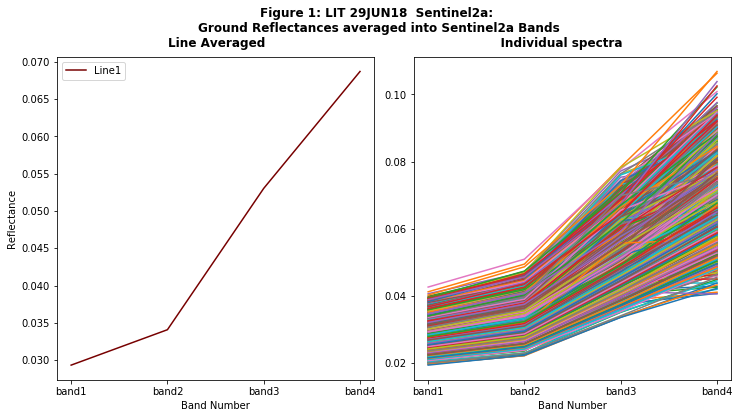

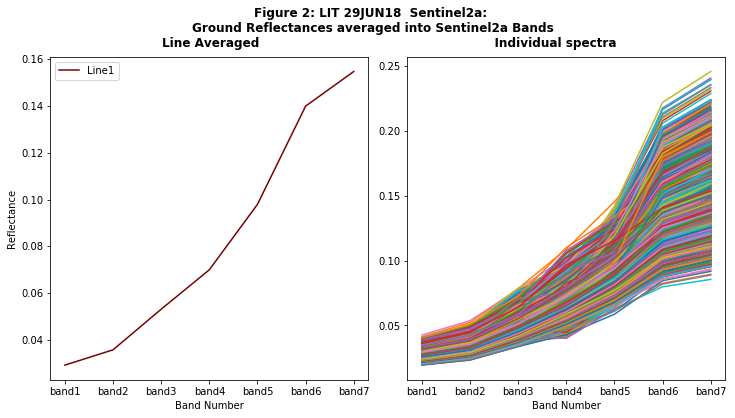

In [16]:
FIG_BandReflectances.FIG_band_reflectances(catty_ls8, result_ls8_df, band_ls8, colpac, output, field_data, fignum)
fignum += 1
FIG_BandReflectances.FIG_band_reflectances(catty_s2a, result_s2a_df, band_s2a, colpac, output, field_data, fignum)
fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

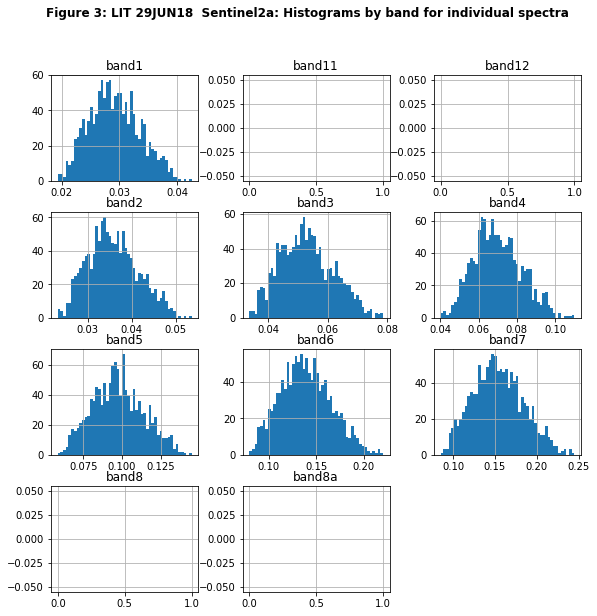

In [17]:
FIG_SpecHistogram.FIG_spec_histogram(catty_s2b, output, field_data, fignum)
fignum += 1

### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [18]:
drone

,timestamp,latitude,longitude,altitude,relaltitude,roll,pitch,yaw,336.54,336.99,...,818.20,818.69,819.18,819.67,820.16,820.65,821.14,821.63,822.12,822.61
0,2018-06-29T01:31:45.38Z,-13.181537,130.788699,275.95,49.76,0.255,-0.180,-0.132,-0.0050,0.0292,...,0.1839,0.1839,0.1859,0.1886,0.1869,0.1834,0.1877,0.1852,0.1849,0.1854
1,2018-06-29T01:31:46.96Z,-13.181556,130.788658,275.99,49.80,0.221,-0.298,-0.124,0.0150,0.0243,...,0.2167,0.2171,0.2184,0.2195,0.2178,0.2180,0.2165,0.2156,0.2171,0.2167
2,2018-06-29T01:31:48.86Z,-13.181483,130.788650,276.02,49.83,0.116,-0.279,-0.119,0.0200,0.0146,...,0.1755,0.1765,0.1762,0.1720,0.1741,0.1774,0.1756,0.1744,0.1752,0.1759
3,2018-06-29T01:31:49.06Z,-13.181470,130.788650,276.01,49.82,0.087,-0.229,-0.120,0.0050,0.0097,...,0.1497,0.1501,0.1490,0.1515,0.1515,0.1508,0.1523,0.1523,0.1491,0.1489
4,2018-06-29T01:31:49.25Z,-13.181457,130.788649,276.01,49.82,0.069,-0.227,-0.127,0.0050,0.0195,...,0.1606,0.1618,0.1592,0.1615,0.1599,0.1608,0.1619,0.1600,0.1588,0.1604
5,2018-06-29T01:31:49.45Z,-13.181450,130.788649,276.01,49.82,0.093,-0.226,-0.128,0.0050,0.0292,...,0.1740,0.1755,0.1747,0.1758,0.1751,0.1754,0.1766,0.1739,0.1752,0.1744
6,2018-06-29T01:31:49.65Z,-13.181437,130.788649,276.01,49.82,0.111,-0.214,-0.126,0.0350,0.0292,...,0.1701,0.1701,0.1718,0.1705,0.1717,0.1703,0.1720,0.1698,0.1696,0.1709
7,2018-06-29T01:31:49.85Z,-13.181420,130.788648,275.99,49.80,0.130,-0.167,-0.127,0.0150,0.0146,...,0.1710,0.1697,0.1713,0.1729,0.1722,0.1718,0.1720,0.1713,0.1686,0.1719
8,2018-06-29T01:31:50.08Z,-13.181401,130.788648,275.97,49.78,0.121,-0.154,-0.131,0.0150,0.0292,...,0.1661,0.1682,0.1670,0.1663,0.1697,0.1678,0.1685,0.1672,0.1680,0.1669
9,2018-06-29T01:31:50.28Z,-13.181386,130.788648,275.96,49.77,0.104,-0.151,-0.134,0.0150,0.0049,...,0.1691,0.1701,0.1699,0.1720,0.1712,0.1708,0.1720,0.1703,0.1706,0.1689


In [ ]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'])#, format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

catty_ls8['Solar_angle'] = catty_ls8.apply(solar_angle, axis=1)
catty_s2a['Solar_angle'] = catty_s2a.apply(solar_angle, axis=1)
catty_s2b['Solar_angle'] = catty_s2b.apply(solar_angle, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [ ]:
ground_brdf_ls8, hb, br = BRDF.ReadAndCalc(brdf_data, catty_ls8, ['','','','Landsat8'])
ground_brdf_s2a, hb, br = BRDF.ReadAndCalc(brdf_data, catty_s2a, ['','','','Sentinel2a'])
ground_brdf_s2b, hb, br = BRDF.ReadAndCalc(brdf_data, catty_s2b, ['','','','Sentinel2b'])


### Choose bands for Landsat 8 and Sentinel satellite data

In [ ]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

In [ ]:
FIG_BandExtents.FIG_band_extents(dee, band_min, band_max, output, field_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [ ]:
StartCorner = 'SE'

ground_brdf_ls8 = FudgeGPS.fudge_gps(ground_brdf_ls8, Corners, RockWalk, StartCorner)
ground_brdf_s2a = FudgeGPS.fudge_gps(ground_brdf_s2a, Corners, RockWalk, StartCorner)
ground_brdf_s2b = FudgeGPS.fudge_gps(ground_brdf_s2b, Corners, RockWalk, StartCorner)

### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [ ]:
PrintBRDF.print_brdf(catty_s2a, field_data)

### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [ ]:
ldc, sdc, lquery, squery, lquery2, squery2 = LongQuery.make_long_query(ground_brdf_ls8)

ls8_array, s2a_array, s2b_array, ls8_bigarray, s2a_bigarray, s2b_bigarray = CreateLongArrays.create_long_arrays_nomask(ldc, sdc, lquery, squery, lquery2, squery2)

# Figure 

### Plot relative locations of field and satellite data

In [ ]:
xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf_s2a, s2a_array, colpac, output, field_data, fignum)
fignum +=1

### Create Australian albers columns for ground_brdf (not used)

In [ ]:
#for i in range(len(ground_brdf)):
#    ground_brdf['Xalbers'], ground_brdf['Yalbers'] = pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][i], ground_brdf['Latitude'][i])
#    
#print(ground_brdf['Xalbers'][4], ground_brdf['Yalbers'][4])
#
#pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][4], ground_brdf['Latitude'][4])

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [ ]:
field_array_ls8, field_array_s2a = CreateManyFieldFromSat.create_many_field_from_sat(ls8_array, s2a_array, ground_brdf_ls8, ground_brdf_s2a, xloc)

# Figure 

### Plot large-area context RGB array for Satellite data

In [ ]:
FIG_ManyBigRGB.FIG_many_bigRGB(ls8_array, s2a_array, s2b_array, ls8_bigarray, s2a_bigarray, s2b_bigarray, output, field_data, fignum)
fignum += 1

In [ ]:
drone.plot('timestamp', ['roll', 'pitch', 'relaltitude'], figsize=(10,10), colors=['red','green','blue'])

# Figure 

### Plot RGB array for Satellite data

In [ ]:
FIG_ManyRGB.FIG_many_RGB(ls8_array, s2a_array, s2b_array, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

In [ ]:
FIG_FieldRGB.FIG_field_RGB(field_array_s2a, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [ ]:
fls8_df, fs2a_df, fs2b_df = CreateManyStats.create_manystats(ls8_array, s2a_array, s2b_array, ls8_bad_days, s2a_bad_days, s2b_bad_days, ground_brdf_ls8, ground_brdf_s2a, field_data)

In [ ]:
FIG_ManySatFieldBands.FIG_many_sat_field_bands(ls8_array, s2a_array, s2b_array, fls8_df, fs2a_df, fs2b_df, output, field_data, fignum)
fignum += 1

In [ ]:
FIG_MultiTimeLine.FIG_multi_time_line(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)
fignum+=1

In [ ]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")